In [ ]:
import pandas as pd
import numpy as np
from datetime import date
import requests
from bs4 import BeautifulSoup
import unicodedata
import time
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk import sent_tokenize, word_tokenize
nltk.download('punkt')
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Scraping Loop

In [ ]:
# creating url iterator 
start_date = date(2020, 1, 1)
end_date = date(2021, 1, 1)
daterange = pd.date_range(start_date, end_date)

dates = pd.DataFrame({"dates":daterange})
dates = dates.iloc[::5, :].reset_index(drop=True)

after = dates.iloc[::2].reset_index(drop=True)  # even
before = dates.iloc[1::2].reset_index(drop=True)  # odd

# the way their html functions requires overlapping date sets
after_offset = after + pd.DateOffset(1)
before_offset = before + pd.DateOffset(-1)

# format
after = after.dates.dt.strftime('%Y-%m-%d')
before = before.dates.dt.strftime('%Y-%m-%d')
after_offset = after_offset.dates.dt.strftime('%Y-%m-%d')
before_offset = before_offset.dates.dt.strftime('%Y-%m-%d')

# create date list
urls = []
for j in range(0,36):
  url_1 = "https://union.barstoolsports.com/stories/latest?limit=1500&after="+ after[j] + "&before=" + before[j] +"&type=standard_post"
  urls.append(url_1)
  url_2 = "https://union.barstoolsports.com/stories/latest?limit=1500&after="+ before_offset[j] + "&before=" + after_offset[j+1] +"&type=standard_post"
  urls.append(url_2)

# empty dataframe to append
Barstool = pd.DataFrame({
        "dates":[] ,
        "author": [],
        "title": [],
        "text": [],
        "comments": [],
        "blockquotes": [],
        "twitter": [],
        "instagram": [],
        "tiktok": [],
        "youtube": [],
        "images": [],
        "streamable": [],
        'gifs': []
        })

In [ ]:
for i in range(len(urls)):
  # read in directory
  info = pd.read_json(urls[i])['url']
  print("---", i, "---")
  # each directory has hundreds of blogs in chronological order
  for k in range(len(info)):
    try:
      print("---", k,"---")
      url = info[k]
      page = requests.get(url)
      soup = BeautifulSoup(page.content,"html.parser")
      words = [t.get_text() for t in soup.select(".story__content")][0]
      words = unicodedata.normalize('NFKD',words)
      author = [w.get_text() for w in soup.select(".authorName")][0]
      date = [d.get_text() for d in soup.select(".timestamp")][0]
      title = [p.get_text() for p in soup.select(".story__title")][0]
      try:
        comments = soup.find_all("span", { "class":"jsx-3955762224" })[0].text
      except:
        continue
      links = soup.select('.iframely-embed')
      links = [i.findChild("a")['href'] for i in links]
      twitter = len([s for s in links if "twitter.com" in s])
      insta = len([s for s in links if "instagram.com" in s])
      tiktok = len([s for s in links if "tiktok.com" in s])
      streamable = len([s for s in links if "streamable.com" in s])
      youtube = len([s for s in links if "youtube.com" in s])
      imgs = len(soup.findAll("img", {"class": "fr-fic fr-dib bs-image"}))
      imgs = imgs + len(soup.findAll("img",{'class':'alignnone'}))
      blockquotes = len(soup.select('blockquote'))
      gifs = len(soup.find_all("video"))

      frame = pd.DataFrame({
            "dates": date,
            "author": author,
            "title": title,
            "text": words,
            "comments": [comments],
            "blockquotes": [blockquotes],
            "twitter": [twitter],
            "instagram": [insta],
            "tiktok": [tiktok],
            "youtube": [youtube],
            "images": [imgs],
            "streamable": [streamable],
            'gifs': [gifs]
            })
    
      Barstool = Barstool.append(frame)
    except:
      print("Barstool Booted me")
      print("Or some other error")
      print("Waiting 30 seconds...")
      time.sleep(30)
      continue


with open('./Barstool_2016.pkl', 'wb') as fid:
     pickle.dump(Barstool, fid)


In [ ]:
Barstool.head(20)

In [ ]:
with open('./Barstool_2019.pkl', 'wb') as fid:
     pickle.dump(Barstool, fid)

In [ ]:
Barstool
#!pip install xlsxwriter
#Barstool.to_excel('Barstool_2019.xlsx', engine='xlsxwriter')

# Load Previous Data

In [ ]:
with open(r"/content/Barstool_2020.pkl", "rb") as input_file:
     train = pickle.load(input_file)

In [ ]:
#with open(r"/content/Barstool_2020.pkl", "rb") as input_file:
#     train = pickle.load(input_file)

frame = pd.DataFrame({})

with open(r"/content/drive/MyDrive/Statistics Computer Science/Computer Science/Python/Barstool_2017.pkl", "rb") as input_file:
  train = pickle.load(input_file)

frame = frame.append(train)

with open(r"/content/drive/MyDrive/Statistics Computer Science/Computer Science/Python/Barstool_2018.pkl", "rb") as input_file:
  train = pickle.load(input_file)

frame = frame.append(train)

with open(r"/content/drive/MyDrive/Statistics Computer Science/Computer Science/Python/Barstool_2019.pkl", "rb") as input_file:
  train = pickle.load(input_file)

frame = frame.append(train)

with open(r"/content/drive/MyDrive/Statistics Computer Science/Computer Science/Python/Barstool_2020.pkl", "rb") as input_file:
  train = pickle.load(input_file)

frame = frame.append(train)

frame

In [ ]:
train.drop_duplicates(['dates','author','title'],keep= 'last')
train[train.duplicated(['dates','author','title'])]

train.query('dates == "12/20/2020 12:29 AM"')

,dates,author,title,text,comments,blockquotes,twitter,instagram,tiktok,youtube,images,streamable,gifs
0,12/20/2020 12:29 AM,Jack Mac,I Can Tell Ya One Team That Didn't Play Like C...,We currently have the shirt above available in...,97,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
0,12/20/2020 12:29 AM,Jack Mac,I Can Tell Ya One Team That Didn't Play Like C...,We currently have the shirt above available in...,97,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train['text']= train['text'].str.replace(r"(?<![A-Z])(?<!^)([A-Z])",r" \1")
train['text']= train['text'].str.replace(' +', ' ')
train['comments'] = train['comments'].astype(int)
train['dates'] = pd.to_datetime(train['dates'])
train['year']=train['dates'].dt.year
train['month']=train['dates'].dt.month
train['day']=train['dates'].dt.day
train.reset_index(drop=True,inplace=True)
train

,dates,author,title,text,comments,blockquotes,twitter,instagram,tiktok,youtube,images,streamable,gifs,year,month,day
0,2020-01-05 23:36:00,Coley Mick,"The Penis Man Will Not Stop Terrorizing Tempe,...",I’ve always been enamored with graffiti. Some ...,2,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2020,1,5
1,2020-01-05 23:13:00,Coley Mick,"Jason Garrett Is Officially, Finally, Out As H...",It’s insane this took as long as it did. And I...,7,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1,5
2,2020-01-05 22:24:00,Jordie,Jadeveon Clowney Needs To Be Locked Away For L...,What in the fucking fuck? Carson Wentz makes i...,10,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1,5
3,2020-01-05 21:42:00,Kate,Thankfully Eagles Don't Need Tailbones To Fly,"Tailbone has left the chat, indeed. But, pshhh...",9,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2020,1,5
4,2020-01-05 21:37:00,Coley Mick,"Kirk ""Hammer Cock"" Cousins Just Beat The Saint...",Let’s let another Minnesota legend tell it: Th...,9,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34163,2020-12-20 04:15:00,Grinnelli,It's Spittin' Chiclets Vs The People Right Now...,NHL21 is here and we are giving it a test run ...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,12,20
34164,2020-12-20 02:09:00,Jack Mac,John Metchie Just (Legally) Murdered A Florida...,Holy. SHIT. The individual who committed that ...,49,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2020,12,20
34165,2020-12-20 01:39:00,Robbie Fox,Rob Font Returns In A Big Bad Way For The New ...,BOOOOM!!! Pinpoint precision from Rob Font of ...,6,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,12,20
34166,2020-12-20 01:16:00,Robbie Fox,Greg Hardy Just Got TKO'd For The Very First T...,IT' S A CHRISTMAS MIRACLE! Listen - I don't re...,36,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.0,2020,12,20


126

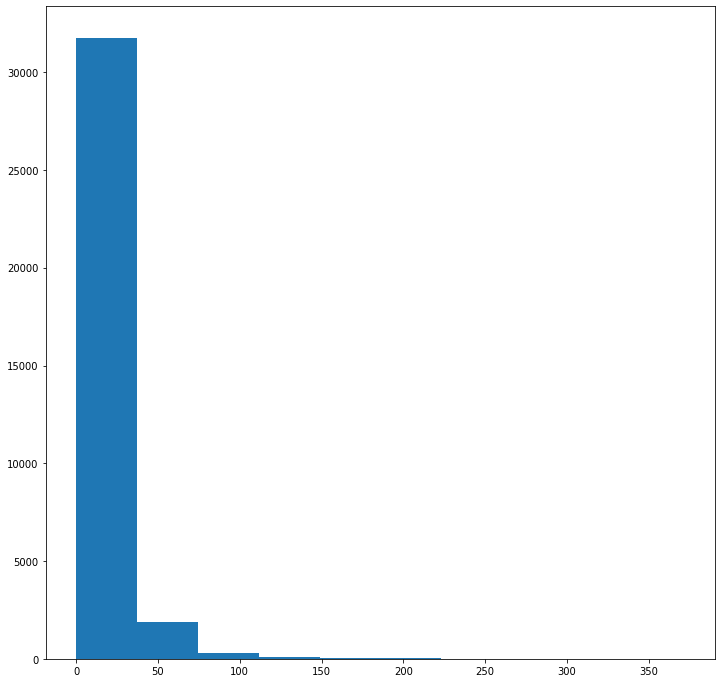

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.hist(train.query('comments < 400')['comments']);

train['comments'].describe()

len(train['author'].unique())

In [ ]:
# faster lexicon analysis
#https://www.nltk.org/api/nltk.sentiment.html
#https://github.com/cjhutto/vaderSentiment#about-the-scoring

sid = SentimentIntensityAnalyzer()
train['sentiment_score'] = 0
for i in range(train.shape[0]):
  print(i)
  textsample = train['text'][i]
  sentences = sent_tokenize(textsample)  

  sent = []
  for j in sentences:
    ss = sid.polarity_scores(j)
    sent.append(ss['compound'])
  
  train.iloc[i,-1:] = np.mean(sent)
  

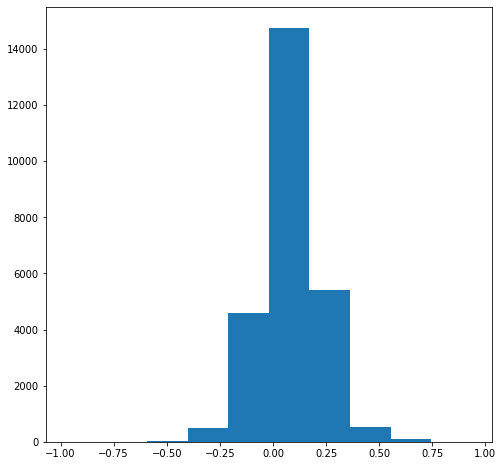

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(train['sentiment_score']);

In [ ]:
import math as math
from scipy import stats
import statsmodels.discrete.count_model as reg_models
# removing date variables helped. What if I scaled
frame =  train.iloc[:,4:14]
#frame = frame.query('comments < 50')
frame.reset_index(drop=True,inplace=True)
train_idxs = np.random.choice(range(frame.shape[0]), size = round(0.7*len(frame)), replace = False)
val_idxs = np.array([idx for idx in range(frame.shape[0]) if idx not in train_idxs])
y_train = frame['comments'][train_idxs]
x_train = frame.iloc[train_idxs, :].loc[:, frame.columns != 'comments']
x_train.fillna(0,inplace=True)

#res = reg_models.ZeroInflatedPoisson(endog=y_train,exog=x_train).fit(maxiter=1500)
# need to use negative bin bc var > mean
res = reg_models.ZeroInflatedNegativeBinomialP(endog=y_train,exog=x_train).fit(maxiter=100)

In [ ]:
print(res.summary())

                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                comments   No. Observations:                19798
Model:             ZeroInflatedPoisson   Df Residuals:                    19789
Method:                            MLE   Df Model:                            8
Date:                 Thu, 07 Jan 2021   Pseudo R-squ.:                 -0.7740
Time:                         00:24:35   Log-Likelihood:            -1.0055e+05
converged:                        True   LL-Null:                       -56683.
Covariance Type:             nonrobust   LLR p-value:                     1.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
inflate_const      -1.1478        nan        nan        nan         nan         nan
blockquotes         0.3011        nan        nan        nan         nan         nan
twitter             0.02

In [ ]:
train.author.unique()

array(['El Presidente', 'Reags', 'Jordie', 'Carrabis', 'Nate', 'hubbs',
       'Gay Pat', 'Jerry Thornton', 'Chaps', 'Riggs', 'Glenny Balls',
       'Robbie Fox', '610', 'Trent', 'Rone', 'Jack Mac', 'Clem',
       'Francis', 'Tummy Sticks', 'Smitty', 'Feitelberg', 'Kmarko',
       'Greenie', 'Frank The Tank', 'KFC', 'Pat', 'The Wonton Don',
       'Chief', 'Big Cat', 'Grinnelli', 'Coley Mick', 'OLD -- Clem',
       'PFT Commenter', "Sam's Army", 'Banks', 'Julie Stewart-Binks',
       'GasMoneyBob', 'RDT', 'Pat McAfee', 'Failing Upwards',
       'Rear Admiral', 'Young Pageviews', 'Liz Gonzales',
       'Donovan McNate', 'Devlin', 'Caleb Pressley', 'Ria', 'Carl',
       'Barstool Heartland', 'White Sox Dave', 'Rico Bosco',
       'Gone Patrol', 'Blackjack Fletcher', 'The Hound', 'Yak',
       'Barstool Radio', 'Chicks In The Office', 'The Cousins',
       'Barstool Breakfast', 'Mikey Fowler', 'Kayce Smith',
       'Tommy Smokes', 'Zah ', 'Kate', 'Pros and Joes', 'Handsome Hank',
       '

In [ ]:
np.exp(1.08)
np.mean(y_train)
np.var(y_train)

37.213201463381296

In [ ]:
x_train[x_train.isnull().any(axis=1)]
sum(y_train.isnull())
len(frame)
frame.shape[0]

# BERT Sentiment Analysis no bueno

In [ ]:
# This will take too long
# Allocate a pipeline for sentiment-analysis
# Uses DistilBert trained on SST-2
#https://huggingface.co/transformers/quicktour.html
classifier = pipeline('sentiment-analysis')

cat['sentiment_score'] = 0
for i in range(2):
  print(i)
  textsample = cat['text'][i]
  sentences = sent_tokenize(textsample)  
  words = word_tokenize(textsample)  
  result = classifier(sentences)

  sent = []
  for j in range(len(result)):
    sent.append(result[j]['label'])
  
  cat.iloc[i,-1:] = np.sum(np.where(np.array(sent, copy=False) == "POSITIVE",1,-1))

0
1


# WordClouds

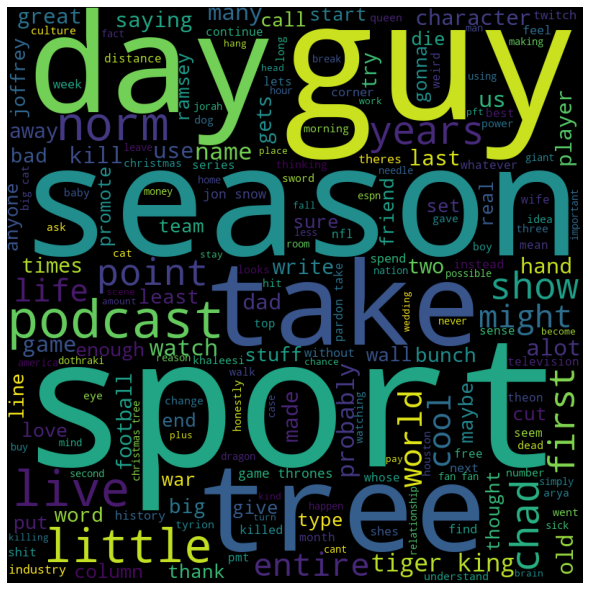

In [ ]:
cat = train.query('author == "PFT Commenter"').reset_index(drop=True)
comment_words = '' 
stopwords = set(STOPWORDS) 
words = ['much','let','tags','re','everyone','make','coming','trying','really',
         'keep','even','move','better','time','going','getting','want',
         'think','now','know','one','going','need','though','say','look','still',
         'well','said','tell','right','back','will','new','see','go','something',
         'around','see','actually','someone','thing','didn','alway','another',
         'talking','don','anything','people','year','good','ll','doesn','got',
         'things','given','ve','every','way','thats','dont','hes','hell','didnt','come','im']
stopwords.update(words)
lis = []
for i in cat.text:
  i = str(i) 
  tokens = i.split() 

  for j in range(len(tokens)): 
    tokens[j] = tokens[j].lower() 

  comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 


# Debug Loop

In [ ]:
Barstool = pd.DataFrame({
        "dates":[] ,
        "author": [],
        "title": [],
        "text": [],
        "comments": [],
        "blockquotes": [],
        "twitter": [],
        "instagram": [],
        "tiktok": [],
        "youtube": [],
        "images": [],
        "streamable": [],
        'gifs': []
        })



In [ ]:
urls

In [ ]:
info = pd.read_json(urls[0])['url']
#url = info[75]
url = "https://www.barstoolsports.com/blog/448160/kelly-rohrbach-has-been-cast-as-c-j-parker-in-the-upcoming-baywatch-movie-starring-the-rock"
url = "https://www.barstoolsports.com/blog/448032/late-night-letter"
page = requests.get(url)
soup = BeautifulSoup(page.content,"html.parser")
words = [t.get_text() for t in soup.select(".story__content")][0]
words = unicodedata.normalize('NFKD',words)
author = [w.get_text() for w in soup.select(".authorName")][0]
date = [d.get_text() for d in soup.select(".timestamp")][0]
title = [p.get_text() for p in soup.select(".story__title")][0]

comments = soup.find_all("span", { "class":"jsx-3955762224" })[0].text
links = soup.select('.iframely-embed')
links = [i.findChild("a")['href'] for i in links]
links2 = soup.select('.story__content')
links2 = [i.findChild("figure") for i in links2]
if type(links2[0]) != type(None):
  links2 = [i.findChild("a")['href'] for i in links2]
  links += links2
twitter = len([s for s in links if "twitter.com" in s])
insta = len([s for s in links if "instagram.com" in s])
tiktok = len([s for s in links if "tiktok.com" in s])
streamable = len([s for s in links if "streamable.com" in s])
youtube = len([s for s in links if "youtube.com" in s])
imgs = len(soup.findAll("img", {"class": "fr-fic fr-dib bs-image"}))
imgs = imgs + len(soup.findAll("img",{'class':'alignnone'}))
blockquotes = len(soup.select('blockquote'))
gifs = len(soup.find_all("video"))

frame = pd.DataFrame({
            "dates": date,
            "author": author,
            "title": title,
            "text": words,
            "comments": [comments],
            "blockquotes": [blockquotes],
            "twitter": [twitter],
            "instagram": [insta],
            "tiktok": [tiktok],
            "youtube": [youtube],
            "images": [imgs],
            "streamable": [streamable],
            'gifs': [gifs]
            })
    
Barstool = Barstool.append(frame)

In [ ]:
Barstool

,dates,author,title,text,comments,blockquotes,twitter,instagram,tiktok,youtube,images,streamable,gifs
0,1/05/2016 9:22 PM,El Presidente,The Giants Are In Disarray Ending The Myth Onc...,"Cry Eli Cry! Cry Eli Cry! EAST RUTHERFORD, N....",107,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,1/05/2016 9:22 PM,El Presidente,The Giants Are In Disarray Ending The Myth Onc...,"Cry Eli Cry! Cry Eli Cry! EAST RUTHERFORD, N....",107,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,1/05/2016 9:22 PM,El Presidente,The Giants Are In Disarray Ending The Myth Onc...,"Cry Eli Cry! Cry Eli Cry! EAST RUTHERFORD, N....",107,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
0,1/05/2016 5:50 PM,KFC,Guess That Ass Featuring A Boner Inducing Video,And the answer is Gayana Bagdasarvan. And she ...,11,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
0,1/05/2016 4:30 PM,Clem,Kelly Rohrbach Has Been Cast As C.J. Parker In...,Huffington Post- The “Baywatch” reboot just fo...,14,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
0,1/05/2016 4:30 PM,Clem,Kelly Rohrbach Has Been Cast As C.J. Parker In...,Huffington Post- The “Baywatch” reboot just fo...,14,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0
0,1/05/2016 4:03 AM,Caleb Pressley,Late Night Letter,Something I got. Just thought I’d share.Daddy ...,38,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0,1/05/2016 4:30 PM,Clem,Kelly Rohrbach Has Been Cast As C.J. Parker In...,Huffington Post- The “Baywatch” reboot just fo...,14,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0
0,1/05/2016 4:03 AM,Caleb Pressley,Late Night Letter,Something I got. Just thought I’d share.Daddy ...,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
Barstool

,dates,author,title,text,comments,blockquotes,twitter,instagram,tiktok,youtube,images,streamable,gifs
0,1/05/2016 9:22 PM,El Presidente,The Giants Are In Disarray Ending The Myth Onc...,"Cry Eli Cry! Cry Eli Cry! EAST RUTHERFORD, N....",107,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,1/05/2016 9:22 PM,El Presidente,The Giants Are In Disarray Ending The Myth Onc...,"Cry Eli Cry! Cry Eli Cry! EAST RUTHERFORD, N....",107,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,1/05/2016 9:22 PM,El Presidente,The Giants Are In Disarray Ending The Myth Onc...,"Cry Eli Cry! Cry Eli Cry! EAST RUTHERFORD, N....",107,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
0,1/05/2016 5:50 PM,KFC,Guess That Ass Featuring A Boner Inducing Video,And the answer is Gayana Bagdasarvan. And she ...,11,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
0,1/05/2016 4:30 PM,Clem,Kelly Rohrbach Has Been Cast As C.J. Parker In...,Huffington Post- The “Baywatch” reboot just fo...,14,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
0,1/05/2016 4:30 PM,Clem,Kelly Rohrbach Has Been Cast As C.J. Parker In...,Huffington Post- The “Baywatch” reboot just fo...,14,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0
0,1/05/2016 4:03 AM,Caleb Pressley,Late Night Letter,Something I got. Just thought I’d share.Daddy ...,38,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
